In [2]:
import numpy as np
import matplotlib.pyplot as plt

# import the PyCBC package
import pycbc.waveform
from pycbc import types
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal as _lal



/Users/zhongjunbao/miniconda3/envs/04_Gravitational_Wave/lib/python3.11/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


In [3]:
# define the parameters of the binary system

m1 = 30 # solar masses
m2 = 30 # solar masses
distance = 500 # Mpc

frequency_spacing = 1.0/16 # Hz
f_lower = 10 # Hz

inclination = np.pi/3 # radians
phase = 0 # radians

approximant = 'IMRPhenomD'

distance    = 1000  # Mpc


Qn1, Produce frequency domain waveform model and plot the waveform of the signal.

In [4]:
# generate the waveform in frequency domain
h_plus, h_cross = pycbc.waveform.get_fd_waveform(approximant=approximant,
                                            mass1=m1,
                                            mass2=m2,
                                            distance=distance,
                                            f_lower=f_lower,
                                            delta_f=frequency_spacing,
                                            inclination=inclination,
                                            coa_phase=phase)


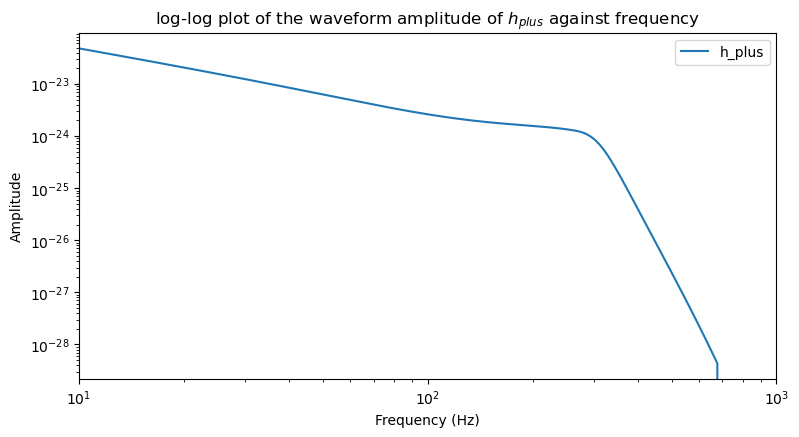

In [5]:
# plot the waveform of h_plus
plt.figure(figsize=(9, 4.5))
plt.plot(h_plus.sample_frequencies, np.abs(h_plus), label='h_plus')
# plt.plot(h_cross.sample_frequencies, np.abs(h_cross), label='h_cross')
plt.xlabel('Frequency (Hz)')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Amplitude')
plt.xlim(10, 1000) 
plt.legend()
plt.title(r'log-log plot of the waveform amplitude of $h_{plus}$ against frequency')
plt.savefig('figures/waveform.png')
plt.show()

From the plot above, the frequency where the merger of the black holes occurs is around $6 \times 10^2 Hz$. 

Qn2, Read data from ASD.txt and plot the amplitude spectral density (ASD).

In [6]:
# read the data from the file
data = np.loadtxt('data/ASD.txt')
frequency = data[:,0]
asd = data[:,1]
psd = asd**2

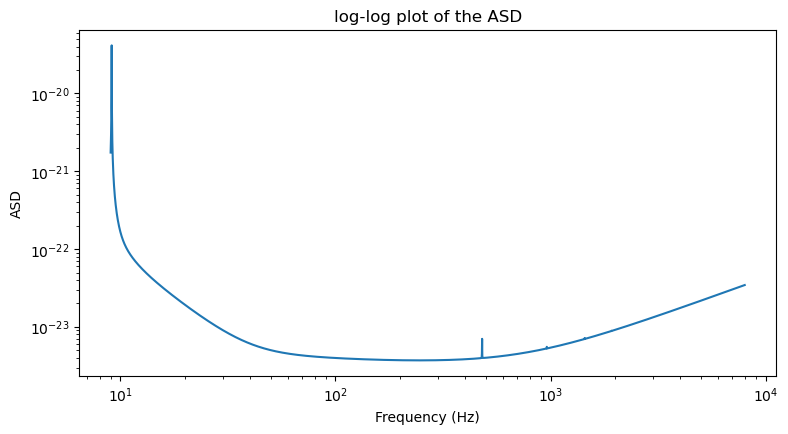

In [7]:
# set the size of the figure
plt.figure(figsize=(9,4.5))
plt.plot(frequency, asd)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('ASD')
plt.title('log-log plot of the ASD')
# plt.savefig('figures/ASD.png')
plt.show()


## Qn3. Plot log-log plot of $\sqrt{f} \times h_{plus}$ and the ASD

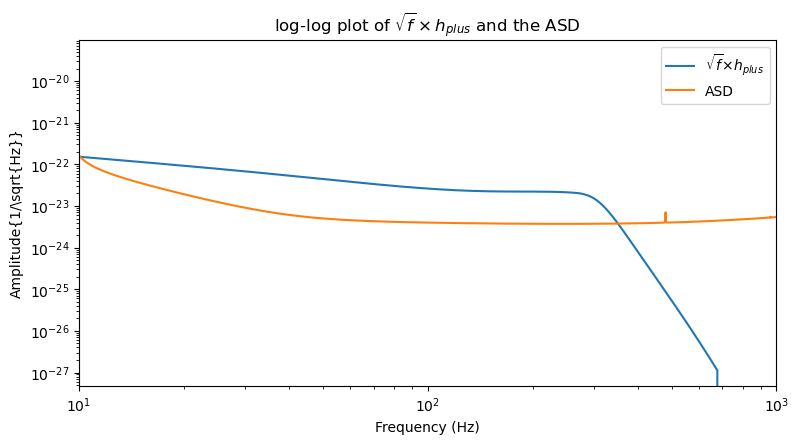

In [8]:
# calculate sqrt(f) * h_plus
sqrt_f_h_plus = np.sqrt(h_plus.sample_frequencies) * h_plus

# plot the sqrt(f) * h_plus and the ASD
plt.figure(figsize=(9,4.5))
plt.plot(h_plus.sample_frequencies, np.abs(sqrt_f_h_plus), label=r'$\sqrt{f} {\times} h_{plus}$')
plt.plot(frequency, asd, label='ASD')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10, 1000)
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'Amplitude{1/\sqrt{Hz}}')
plt.legend()
plt.title(r'log-log plot of $\sqrt{f} \times h_{plus}$ and the ASD')
plt.savefig('figures/sqrt_f_h_plus_ASD.png')
plt.show()



## Qn4 Define antenna pattern functions F_plus and F_cross

In [9]:
# define the F_plus and F_cross functions
def F(theta,phi,psi,polarisation = "plus"):
    if polarisation == "plus":
        return (1+np.cos(theta)**2)/2 * np.cos(2*phi) * np.cos(2*psi) + np.cos(theta) * np.sin(2*phi) * np.sin(2*psi)
    else:
        return (1+np.cos(theta)**2)/2 * np.cos(2*phi) * np.sin(2*psi) - np.cos(theta) * np.sin(2*phi) * np.cos(2*psi)


## Qn5. Compute Signal to Noise Ratio (SNR) for the signal

In [10]:
# define the inner product
def inner_product(h1, h2, Sn, df):
    """Calculate the inner product of two waveforms h1 and h2."""
    return np.abs(np.sum(np.conj(h1) * h2 / Sn)) * df

# define a function that calculates the SNR:
def SNR(a, b, Sn, frequency_spacing):
    """
    Calculate the SNR of a signal a in the presence of noise b.

    SNR = sqrt(4 * <a|b>), where <a|b> is the inner product of a and b and the noise power spectrum Sn.

    Parameters
    ----------
    a : array_like
        The signal template
    b : array_like
        The noisy data
    Sn : array_like
        The noise power spectrum
    frequency_spacing : float
        The frequency spacing of the data

    Returns
    -------
    float
        The signal-to-noise ratio of the signal a in the noisy data b
    """
    # 
    inner = inner_product(a, b, Sn, frequency_spacing)
    return np.sqrt(inner * 4)

In [11]:
# Define the parameters dictionary
parameters = {'theta':0, 'phi':0, 'psi': 0, 'inclination':0, 'phase': 0}

In [12]:
# use f_upper = 1000 Hz
f_upper = 1000

In [13]:
h_plus, h_cross = pycbc.waveform.get_fd_waveform(approximant=approximant,
                                            mass1=m1,
                                            mass2=m2,
                                            distance=distance,
                                            f_lower=f_lower,
                                            f_upper=f_upper,
                                            delta_f=frequency_spacing,
                                            inclination=parameters['inclination'],
                                            coa_phase=parameters['phase'])

# calculate the detector output
h = np.array(F(parameters['theta'], parameters['phi'], parameters['psi'], 'plus') * h_plus + F(parameters['theta'], parameters['phi'], parameters['psi'], 'cross') * h_cross)
h_frequency = h_plus.sample_frequencies
frequency_spacing = h_frequency[1] - h_frequency[0]



In [14]:
# use intrapolation to convert ASD to the same frequency as h
asd_interpolated = interp1d(frequency, asd, kind='linear', fill_value='extrapolate')(h_frequency)
psd_interpolated = asd_interpolated**2

In [15]:
optimum_SNR = SNR(h, h, psd_interpolated, frequency_spacing)
print (f'Optimum SNR: {optimum_SNR}')

Optimum SNR: 37.93334693638376


## Qn6. 

In [16]:
number_of_points = 10000

In [17]:
# draw random values of theta
theta_values = np.random.uniform(0, 2*np.pi, number_of_points)

# draw random values of phi
phi_values = np.random.uniform(0, np.pi, number_of_points)

# draw random values of psi
psi_values = np.random.uniform(0, np.pi, number_of_points)

# draw random values of inclination
inclination_values = np.random.uniform(0, np.pi, number_of_points)

# draw random values of phase
phase_values = np.random.uniform(0, 2*np.pi, number_of_points)

# iterate over the parameters and calculate the SNR
SNRs = []
for i in range(0, number_of_points):
    parameters = {'theta': theta_values[i], 'phi': phi_values[i], 'psi': psi_values[i], 'inclination':inclination_values[i], 'phase': phase_values[i]}
    h_plus, h_cross = pycbc.waveform.get_fd_waveform(approximant=approximant,
                                            mass1=m1,
                                            mass2=m2,
                                            distance=distance,
                                            f_lower=f_lower,
                                            f_upper=f_upper,
                                            delta_f=frequency_spacing,
                                            inclination=parameters['inclination'],
                                            coa_phase=parameters['phase'])

    # calculate the detector output
    h = np.array(F(parameters['theta'], parameters['phi'], parameters['psi'], 'plus') * h_plus + F(parameters['theta'], parameters['phi'], parameters['psi'], 'cross') * h_cross)
    h_frequency = h_plus.sample_frequencies
    frequency_spacing = h_frequency[1] - h_frequency[0]

    # use intrapolation to convert ASD to the same frequency as h
    asd_interpolated = interp1d(frequency, asd, kind='linear', fill_value='extrapolate')(h_frequency)
    psd_interpolated = asd_interpolated**2

    # SNR
    SNRs.append(SNR(h, h, psd_interpolated, frequency_spacing))


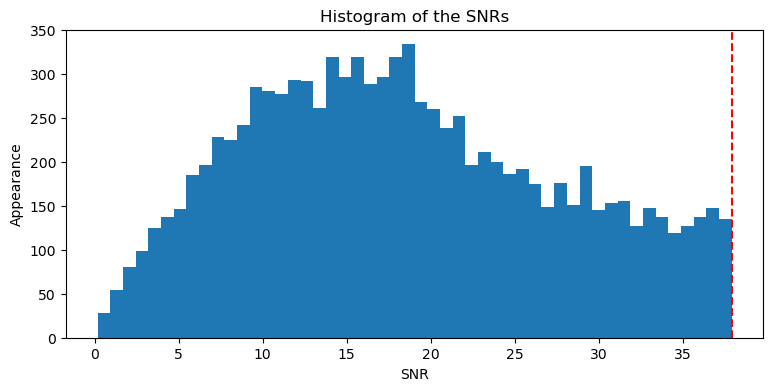

Maximum SNR: 37.92275781900814
Average SNR: 18.519057192278414


In [18]:
# plot the histogram of the SNRs
plt.figure(figsize=(9,4))
plt.hist(SNRs, bins=50)
plt.xlabel('SNR')
plt.ylabel('Appearance')
# plot the maximum SNR
plt.axvline(x=optimum_SNR, color='r', linestyle='--', label='Optimum SNR')
plt.title('Histogram of the SNRs')
plt.savefig('figures/SNR_histogram.png')
plt.show()

# print the maximum SNR
print (f'Maximum SNR: {np.max(SNRs)}')

# print average SNR
print (f'Average SNR: {np.mean(SNRs)}')